In [168]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas.tseries.offsets import MonthEnd
file_dir = '/home/luke/workspace/Sector-Analysis/Luke_working_space/Plot generating codes/linear_regression/'


In [2]:
%run -i financial_sector_functions.py

In [3]:
def return_function(df):
    if type(df)!=pd.DataFrame:
        df = pd.DataFrame(df)
    out_df = (df.shift(-1)-df)/df
    return out_df

In [4]:
data = pd.read_csv("financial_sector_clean_return_space_Dec_13.csv")
data.index = pd.DatetimeIndex(data.iloc[:,[0]].values.flatten())
data = data.iloc[:,1:]

sp500 = pd.read_csv('/home/luke/workspace/Sector-Analysis/data/CFRM521_final_project/SPX500.csv')
sp500.index = pd.DatetimeIndex(sp500.iloc[:,[0]].values.flatten())
sp500 = sp500.iloc[:,[1]]
sp500 = return_function(sp500)
sector_return = data.iloc[:,[0]]
x_data = data.iloc[:,1:]
sector_return,x_data = model_data(sector_return,x_data)
sector_return,sp500 = model_data(sector_return,sp500)

# sector_beat_benchmark = pd.DataFrame((sector_return.values > sp500.values)*1,index = sector_return.index,columns = ['IFY beat benchmark'])

In [5]:
x = x_data
x = sm.add_constant(x)
y = sector_return

In [6]:
model = sm.OLS(y,x)
result = model.fit()

In [7]:
coef_pval = pd.DataFrame(result.pvalues).T
coef = pd.DataFrame(result.params).T
coef_pval.index = [10]

In [8]:
# pd.DataFrame(result.predict(x),columns =['fit'])

In [48]:
def linear_fit_function(x,y,benchmark,nunmber_of_years_lookback,month_forecast):
    y,benchmark = model_data(y,benchmark)
    logistic_result_dict = {}
    coef_all_df = pd.DataFrame()
    accuracy_dict = {}
    y_prediction_dict ={}
    number_of_runs = 0.0
    
    coef_pval_all = pd.DataFrame()
    coef_all = pd.DataFrame()
    for dt_index in x.index[x.index>=x.index.min()+pd.DateOffset(years = nunmber_of_years_lookback)][:-(month_forecast-1)]:
        begin_index,end_index = dt_index+pd.DateOffset(years = -nunmber_of_years_lookback)+MonthEnd(0),dt_index+MonthEnd(-1)
        selection = (x.index>=begin_index) & (x.index <= end_index)
        spliced_x = x[selection]
        spliced_y = y[selection]

        assert(len(spliced_x.index)==nunmber_of_years_lookback*12)
        model = sm.OLS(spliced_y,spliced_x)
        result = model.fit()
        
        coef_pval = pd.DataFrame(result.pvalues).T
        coef_pval.index = [dt_index]
        coef_pval_all = pd.concat([coef_pval_all,coef_pval])
               
        coef = pd.DataFrame(result.params).T
        coef.index = [dt_index]
        coef_all = pd.concat([coef_all,coef])
        
        test_begin_index,test_end_index = dt_index+pd.DateOffset(months=+1)+MonthEnd(-1),dt_index+pd.DateOffset(months=+month_forecast)+MonthEnd(-1)
        test_selection = (x.index>=test_begin_index) & (x.index<=test_end_index)
        test_x = x[test_selection]
        test_y = y[test_selection]
        test_benchmark = benchmark[test_selection]
        assert(len(test_y)==month_forecast)
        assert(all(test_benchmark.index == test_y.index))
        y_prediction = pd.DataFrame(result.predict(test_x),index =test_x.index,columns =['fit'])
        y_prediction_dict[dt_index] = y_prediction
#         import pdb
#         pdb.set_trace()
        forecast_df = pd.DataFrame((y_prediction.values>test_benchmark.values)*1,index = y_prediction.index)
        realized_df = pd.DataFrame((test_y.values>test_benchmark.values)*1,index =test_y.index)
        accuracy_df = pd.DataFrame((forecast_df.values==realized_df.values)*1,index=realized_df.index)
        accuracy_dict[dt_index] = accuracy_df
        number_of_runs +=1

    mean_accuracy_list = []
    for key,value in accuracy_dict.iteritems():
        mean_accuracy_list.append((value.values.flatten()))
    average_accuracy = np.mean(mean_accuracy_list)
    return average_accuracy, coef_all, coef_pval_all

In [47]:
all(x_data.index == sector_return.index)

True

In [49]:
result_df = pd.DataFrame()

for year in np.arange(5,12+1):
    for month in np.arange(3,12+1):
        metric,coef_df,coef_pval_df = linear_fit_function(x = x_data,y = sector_return,benchmark=sp500,
                    nunmber_of_years_lookback=year,month_forecast=month)
        result_df.loc[str(year)+" years",str(month)+" month"] = metric

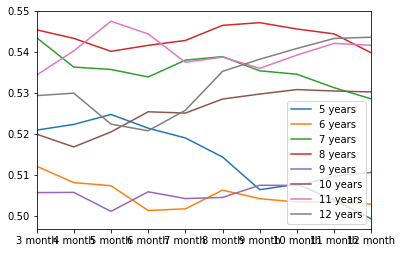

In [52]:
result_df.T.plot()
plt.show()

In [56]:
max_acc = np.max(result_df.values)
max_acc

0.54754098360655734

In [57]:
result_df[result_df == max_acc]

,3 month,4 month,5 month,6 month,7 month,8 month,9 month,10 month,11 month,12 month
5 years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6 years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7 years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8 years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9 years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10 years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11 years,NaN,NaN,0.547541,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12 years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
result_df.max(axis=0).idxmax(),result_df.max(axis=1).idxmax()

('5 month', '11 years')

In [98]:
def correlation_matrix(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure(figsize = (15,15))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid()
#     plt.title('Abalone Feature Correlation')
    labels=df.columns
    ax1.set_xticklabels(labels,fontsize=15)
    ax1.set_yticklabels(labels,fontsize=15)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=[-1,-0.75,-0.5,0.0,0.5,0.75,1])
    plt.show()


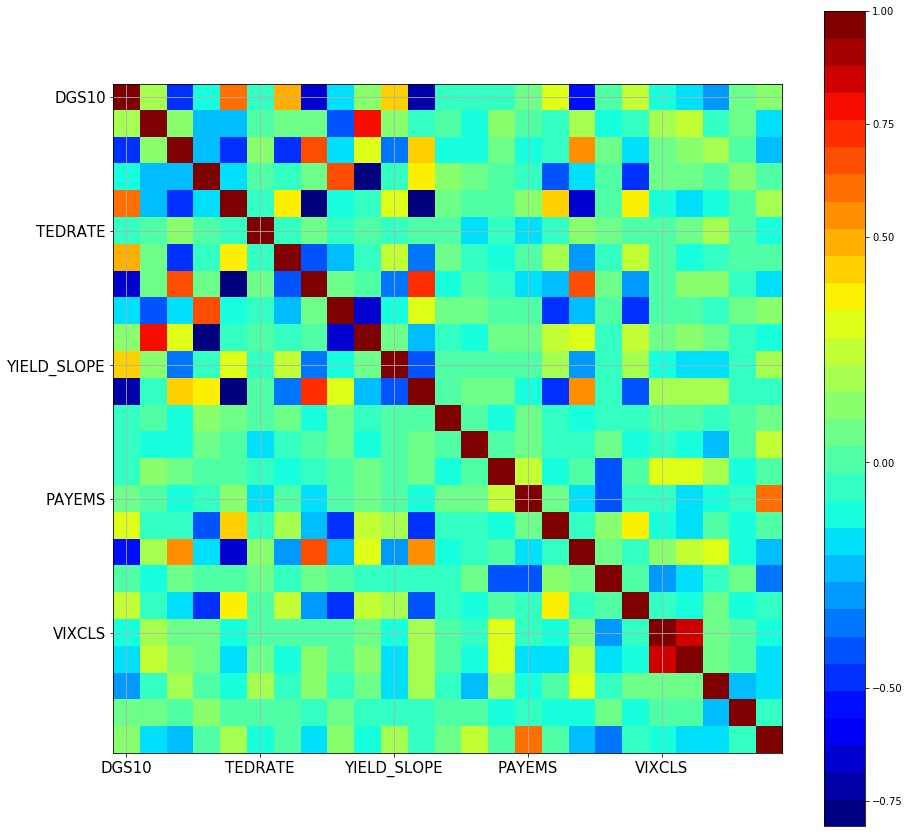

In [99]:
correlation_matrix(x_data)

In [58]:
metric,coef_df,coef_pval_df = linear_fit_function(x = x_data,y = sector_return,benchmark=sp500,
                    nunmber_of_years_lookback=11,month_forecast=5)

In [62]:
sig_coef = avg_pval[avg_pval.values<0.2]
sig_coef

,0
YIELD_SLOPE,1.867396e-01
UMCSENT,9.197685e-02
XOI Index,3.762366e-04
DXY Curncy,3.051999e-02
SPX Index,1.634211e-26


In [162]:
len(avg_pval.index[int_index]),11*12

(9, 132)

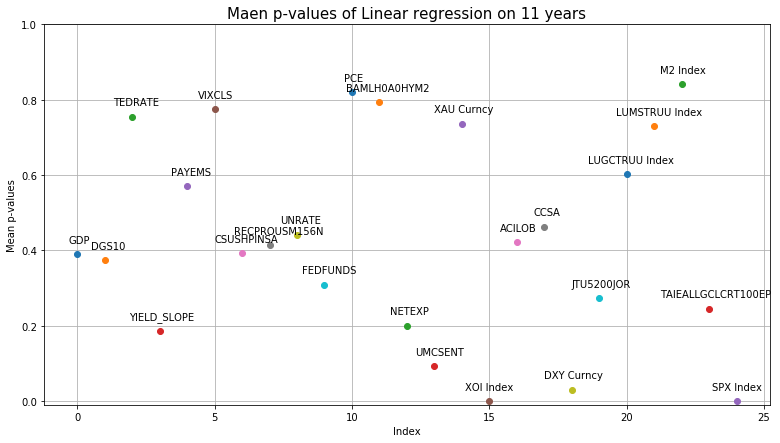

In [174]:
avg_pval = pd.DataFrame(coef_pval_df.apply(np.mean))
plt.figure(figsize = (13,7))
# lab_list = []
for int_index in range(len(avg_pval)):
    plt.plot(int_index,avg_pval.values[int_index],'o')
    text = avg_pval.index[int_index]
    plt.text(int_index-len(text)/10.0,avg_pval.values[int_index][0]+0.03,text,fontdict={'size':10})
plt.grid()
plt.ylim([-0.01,1])
plt.ylabel("Mean p-values",fontdict={'size':10})
plt.xlabel("Index",fontdict={'size':10})
plt.title("Maen p-values of Linear regression on 11 years",fontdict={'size':15})
plt.savefig(file_dir+'linear_regression_average_p_values.png', bbox_inches='tight')
plt.show()

In [128]:
int_index,avg_pval.values[int_index][0]+0.05

(1, 0.4233620245268726)

In [182]:
pd.DataFrame(coef_df.apply(np.mean)).sort_values(by=[0])

,0
BAMLH0A0HYM2,-5.100008
YIELD_SLOPE,-1.192706
FEDFUNDS,-0.678973
JTU5200JOR,-0.410551
DXY Curncy,-0.314313
XOI Index,-0.257550
TEDRATE,-0.217608
LUGCTRUU Index,-0.211003
XAU Curncy,-0.019443
VIXCLS,0.001515


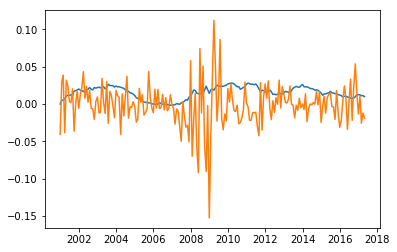

In [103]:
plt.plot(x_data.loc[:,['YIELD_SLOPE']],'b-')
plt.plot(pd.DataFrame((y.values-sp500.values),index = y.index))
plt.show()

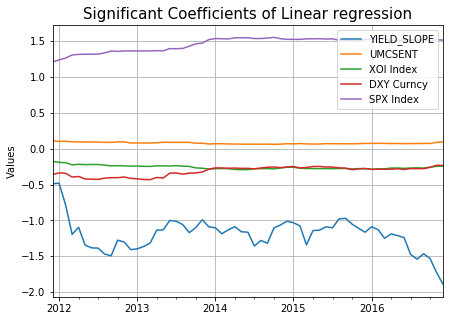

In [176]:
plot = coef_df.loc[:,sig_coef.index].plot(figsize = (7,5))
plot.grid()
patches, labels = plot.get_legend_handles_labels()
plot.legend(patches, labels, loc=1)
plt.title("Significant Coefficients of Linear regression",fontdict={'size':15})
plt.ylabel("Values",fontdict={'size':10})
plt.savefig(file_dir+'linear_regression_rolling_coef_small.png', bbox_inches='tight')
plt.show()

In [183]:
metric_final,coef_df_final,coef_pval_df_final = linear_fit_function(x = x_data,y = sector_return,benchmark=sp500,
                    nunmber_of_years_lookback=8,month_forecast=4)

In [185]:
metric_final
coef_df_final.apply(np.mean)
# ,coef_pval_df_final

GDP                    0.641098
DGS10                  0.719840
TEDRATE                0.021888
YIELD_SLOPE           -1.178940
PAYEMS                 1.671853
VIXCLS                 0.006802
CSUSHPINSA             0.632061
RECPROUSM156N          0.018360
UNRATE                 0.192733
FEDFUNDS              -0.612555
PCE                   -0.118436
BAMLH0A0HYM2         -11.221915
NETEXP                 0.140364
UMCSENT                0.088941
XAU Curncy            -0.017640
XOI Index             -0.293288
ACILOB                 0.133600
CCSA                   0.175803
DXY Curncy            -0.324331
JTU5200JOR            -0.394944
LUGCTRUU Index        -0.316586
LUMSTRUU Index         0.292113
M2 Index               0.077500
TAIEALLGCLCRT100EP     0.040454
SPX Index              1.522339
dtype: float64

In [186]:
x = x_data
y = sector_return
benchmark=sp500
nunmber_of_years_lookback=8
month_forecast=4

In [187]:
y,benchmark = model_data(y,benchmark)
logistic_result_dict = {}
coef_all_df = pd.DataFrame()
accuracy_dict = {}
y_prediction_dict ={}
number_of_runs = 0.0

coef_pval_all = pd.DataFrame()
coef_all = pd.DataFrame()
for dt_index in x.index[x.index>=x.index.min()+pd.DateOffset(years = nunmber_of_years_lookback)][:-(month_forecast-1)]:
    begin_index,end_index = dt_index+pd.DateOffset(years = -nunmber_of_years_lookback)+MonthEnd(0),dt_index+MonthEnd(-1)
    selection = (x.index>=begin_index) & (x.index <= end_index)
    spliced_x = x[selection]
    spliced_y = y[selection]

    assert(len(spliced_x.index)==nunmber_of_years_lookback*12)
    model = sm.OLS(spliced_y,spliced_x)
    result = model.fit()

    coef_pval = pd.DataFrame(result.pvalues).T
    coef_pval.index = [dt_index]
    coef_pval_all = pd.concat([coef_pval_all,coef_pval])

    coef = pd.DataFrame(result.params).T
    coef.index = [dt_index]
    coef_all = pd.concat([coef_all,coef])

    test_begin_index,test_end_index = dt_index+pd.DateOffset(months=+1)+MonthEnd(-1),dt_index+pd.DateOffset(months=+month_forecast)+MonthEnd(-1)
    test_selection = (x.index>=test_begin_index) & (x.index<=test_end_index)
    test_x = x[test_selection]
    test_y = y[test_selection]
    test_benchmark = benchmark[test_selection]
    assert(len(test_y)==month_forecast)
    assert(all(test_benchmark.index == test_y.index))
    y_prediction = pd.DataFrame(result.predict(test_x),index =test_x.index,columns =['fit'])
    y_prediction_dict[dt_index] = y_prediction
#         import pdb
#         pdb.set_trace()
    forecast_df = pd.DataFrame((y_prediction.values>test_benchmark.values)*1,index = y_prediction.index)
    realized_df = pd.DataFrame((test_y.values>test_benchmark.values)*1,index =test_y.index)
    accuracy_df = pd.DataFrame((forecast_df.values==realized_df.values)*1,index=realized_df.index)
    accuracy_dict[dt_index] = accuracy_df
    number_of_runs +=1

mean_accuracy_list = []
for key,value in accuracy_dict.iteritems():
    mean_accuracy_list.append((value.values.flatten()))
average_accuracy = np.mean(mean_accuracy_list)

In [196]:
print(average_accuracy)

0.543367346939


In [188]:
concat_df = pd.DataFrame()
for key in np.sort(y_prediction_dict.keys()):
    value = y_prediction_dict[key]
    concat_df = pd.concat([concat_df,value],1)
clean_df = pd.DataFrame()
for index in concat_df.index:
    temp = concat_df.loc[index,:].dropna()
    temp = pd.DataFrame(temp).T
    temp.columns = range(len(temp.columns))
    clean_df = pd.concat([clean_df,temp])

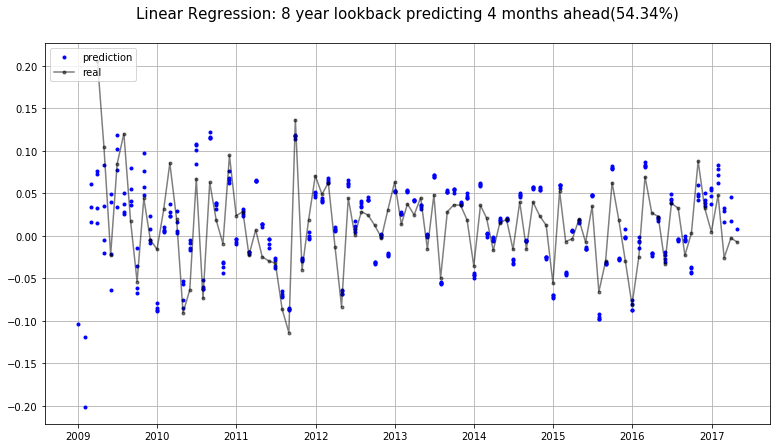

In [198]:
common_index = pd.concat([clean_df,y],1).resample("M").last().dropna().index

plt.figure(figsize = (13,7))
plt.grid()
pred_1,pred_2,pred_3,pred_4,=plt.plot(clean_df,'b.')
real_y,=plt.plot(y.loc[common_index[0]:,:],'k.-',alpha = 0.5)
# base,=plt.plot(clean_df.index,np.repeat(0.5,len(clean_df)),'r-')
plt.legend([pred_1,real_y],['prediction','real'],loc=2)
ttl = plt.title("Linear Regression: 8 year lookback predicting 4 months ahead(54.34%)",fontsize = 15)
ttl.set_position([.5, 1.05])
file_dir_fin = "/home/luke/workspace/Sector-Analysis/Luke_working_space/Plot generating codes/same_lookingback_horizon/"
plt.savefig(file_dir_fin+"linear_8yr_4m.png",bbox_inches='tight')
plt.show()